## Autoencoder based Summary Statistics for ABC

In [1]:
# For jupyternotebook and google collab run this cell to install necessary files
!rm -rf TTSSE_Project
!git clone https://github.com/mayank05942/TTSSE_Project.git
!pip install -e TTSSE_Project/

Cloning into 'TTSSE_Project'...
remote: Enumerating objects: 185, done.
remote: Counting objects: 100% (185/185), done.
remote: Compressing objects: 100% (134/134), done.
remote: Total 185 (delta 81), reused 119 (delta 47), pack-reused 0
Receiving objects: 100% (185/185), 116.65 KiB | 2.16 MiB/s, done.
Resolving deltas: 100% (81/81), done.
Defaulting to user installation because normal site-packages is not writeable
Obtaining file:///home/jupyter-mayank/TTSSE_Project
  Preparing metadata (setup.py) ... done
  Running setup.py develop for TTSE-Project


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dask
from dask.distributed import Client
from dask import delayed, compute
from sklearn.preprocessing import MinMaxScaler
import numpy as np

import multiprocessing as mp
import time

import gillespy2
from gillespy2 import SSACSolver
from gillespy2 import Model, Species, Reaction, Parameter, RateRule, AssignmentRule, FunctionDefinition
from gillespy2 import EventAssignment, EventTrigger, Event
from gillespy2.core.events import *

import TTSSE_Project
from TTSSE_Project.utilities.summarystats.summary_base import SummaryBase
from TTSSE_Project.utilities.priors.uniform_prior import UniformPrior
from TTSSE_Project.utilities.distancefunctions.euclidean import EuclideanDistance
from TTSSE_Project.utilities.perturbationkernels.multivariate_normal import MultivariateNormalKernel
from TTSSE_Project.utilities.epsilonselectors.relative_epsilon_selector import RelativeEpsilonSelector
from TTSSE_Project.inference.abc_inference import ABC
from TTSSE_Project.utilities.distancefunctions import euclidean

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Input,Dense
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Reshape, Conv1DTranspose

import warnings
warnings.filterwarnings('ignore')


2023-08-25 15:43:25,045 - numba.cuda.cudadrv.driver - ERROR - Call to cuInit results in CUDA_ERROR_NO_DEVICE


Sciope logger is now ready. Log directory is /tmp/Sciope_logs


2023-08-25 15:43:25.326613: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-25 15:43:25.446465: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-25 15:43:25.483622: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-08-25 15:43:26.072224: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

## Defining the Genetic Oscillator Model

Input Parameters = 15 and Time Series size = 3 x 200

In [3]:
# Use the model definition below
class Vilar_Oscillator(gillespy2.Model):
    def __init__(self, parameter_values=None):
        gillespy2.Model.__init__(self, name="Vilar_Oscillator")
        self.volume = 1

        # Parameters
        self.add_parameter(gillespy2.Parameter(name="alpha_a", expression=50))
        self.add_parameter(gillespy2.Parameter(name="alpha_a_prime", expression=500))
        self.add_parameter(gillespy2.Parameter(name="alpha_r", expression=0.01))
        self.add_parameter(gillespy2.Parameter(name="alpha_r_prime", expression=50))
        self.add_parameter(gillespy2.Parameter(name="beta_a", expression=50))
        self.add_parameter(gillespy2.Parameter(name="beta_r", expression=5))
        self.add_parameter(gillespy2.Parameter(name="delta_ma", expression=10))
        self.add_parameter(gillespy2.Parameter(name="delta_mr", expression=0.5))
        self.add_parameter(gillespy2.Parameter(name="delta_a", expression=1))
        self.add_parameter(gillespy2.Parameter(name="delta_r", expression=0.2))
        self.add_parameter(gillespy2.Parameter(name="gamma_a", expression=1))
        self.add_parameter(gillespy2.Parameter(name="gamma_r", expression=1))
        self.add_parameter(gillespy2.Parameter(name="gamma_c", expression=2))
        self.add_parameter(gillespy2.Parameter(name="theta_a", expression=50))
        self.add_parameter(gillespy2.Parameter(name="theta_r", expression=100))

        # Species
        self.add_species(gillespy2.Species(name="Da", initial_value=1, mode="discrete"))
        self.add_species(gillespy2.Species(name="Da_prime", initial_value=0, mode="discrete"))
        self.add_species(gillespy2.Species(name="Ma", initial_value=0, mode="discrete"))
        self.add_species(gillespy2.Species(name="Dr", initial_value=1, mode="discrete"))
        self.add_species(gillespy2.Species(name="Dr_prime", initial_value=0, mode="discrete"))
        self.add_species(gillespy2.Species(name="Mr", initial_value=0, mode="discrete"))
        self.add_species(gillespy2.Species(name="C", initial_value=10, mode="discrete"))
        self.add_species(gillespy2.Species(name="A", initial_value=10, mode="discrete"))
        self.add_species(gillespy2.Species(name="R", initial_value=10, mode="discrete"))

        # Reactions
        self.add_reaction(gillespy2.Reaction(name="r1", reactants={'Da_prime': 1}, products={'Da': 1}, rate=self.listOfParameters["theta_a"]))
        self.add_reaction(gillespy2.Reaction(name="r2", reactants={'Da': 1, 'A': 1}, products={'Da_prime': 1}, rate=self.listOfParameters["gamma_a"]))
        self.add_reaction(gillespy2.Reaction(name="r3", reactants={'Dr_prime': 1}, products={'Dr': 1}, rate=self.listOfParameters["theta_r"]))
        self.add_reaction(gillespy2.Reaction(name="r4", reactants={'Dr': 1, 'A': 1}, products={'Dr_prime': 1}, rate=self.listOfParameters["gamma_r"]))
        self.add_reaction(gillespy2.Reaction(name="r5", reactants={'Da_prime': 1}, products={'Da_prime': 1, 'Ma': 1}, rate=self.listOfParameters["alpha_a_prime"]))
        self.add_reaction(gillespy2.Reaction(name="r6", reactants={'Da': 1}, products={'Da': 1, 'Ma': 1}, rate=self.listOfParameters["alpha_a"]))
        self.add_reaction(gillespy2.Reaction(name="r7", reactants={'Ma': 1}, products={}, rate=self.listOfParameters["delta_ma"]))
        self.add_reaction(gillespy2.Reaction(name="r8", reactants={'Ma': 1}, products={'A': 1, 'Ma': 1}, rate=self.listOfParameters["beta_a"]))
        self.add_reaction(gillespy2.Reaction(name="r9", reactants={'Da_prime': 1}, products={'Da_prime': 1, 'A': 1}, rate=self.listOfParameters["theta_a"]))
        self.add_reaction(gillespy2.Reaction(name="r10", reactants={'Dr_prime': 1}, products={'Dr_prime': 1, 'A': 1}, rate=self.listOfParameters["theta_a"]))
        self.add_reaction(gillespy2.Reaction(name="r11", reactants={'A': 1}, products={}, rate=self.listOfParameters["gamma_c"]))
        self.add_reaction(gillespy2.Reaction(name="r12", reactants={'A': 1, 'R': 1}, products={'C': 1}, rate=self.listOfParameters["gamma_c"]))
        self.add_reaction(gillespy2.Reaction(name="r13", reactants={'Dr_prime': 1}, products={'Dr_prime': 1, 'Mr': 1}, rate=self.listOfParameters["alpha_r_prime"]))
        self.add_reaction(gillespy2.Reaction(name="r14", reactants={'Dr': 1}, products={'Dr': 1, 'Mr': 1}, rate=self.listOfParameters["alpha_r"]))
        self.add_reaction(gillespy2.Reaction(name="r15", reactants={'Mr': 1}, products={}, rate=self.listOfParameters["delta_mr"]))
        self.add_reaction(gillespy2.Reaction(name="r16", reactants={'Mr': 1}, products={'Mr': 1, 'R': 1}, rate=self.listOfParameters["beta_r"]))
        self.add_reaction(gillespy2.Reaction(name="r17", reactants={'R': 1}, products={}, rate=self.listOfParameters["delta_r"]))
        self.add_reaction(gillespy2.Reaction(name="r18", reactants={'C': 1}, products={'R': 1}, rate=self.listOfParameters["delta_a"]))

        # Timespan
        self.timespan(np.linspace(0, 200, 200))

In [4]:
model = Vilar_Oscillator()
solver = SSACSolver(model=model)

In [5]:
parameter_names = ['alpha_a', 'alpha_a_prime', 'alpha_r', 'alpha_r_prime',
                   'beta_a', 'beta_r', 'delta_ma', 'delta_mr', 'delta_a',
                   'delta_r', 'gamma_a', 'gamma_r', 'gamma_c', 'theta_a', 'theta_r']

## Defining the simulator

In [6]:
def simulator(params, model = model, transform = True):
    'Simulator takes parameter vector as input and return a time series data of shape 3x200'

    params = params.ravel()
    res = model.run(
            solver = solver,
            timeout = 0.5,
            variables = {parameter_names[i] : params[i] for i in range(len(parameter_names))})

    if res.rc == 33:
        return np.ones((1,3,200))
    if transform:
        # Extract only observed species
        sp_C = res['C']
        sp_A = res['A']
        sp_R = res['R']
        return np.vstack([sp_C, sp_A, sp_R])[np.newaxis,:,:]

    else:
        return res


## Range of the parameters

In [7]:
dmin = [0,    100,    0,   20,   10,   1,    1,   0,   0,   0, 0.5,    0,   0,    0,   0] #lower parameter boundary
dmax = [80,   600,    4,   60,   60,   7,   12,   2,   3, 0.7, 2.5,   4,   3,   70,   300] #upper parameter boundary
true_params = np.asarray([50.0, 500.0, 0.01, 50.0, 50.0, 5.0, 10.0, 0.5, 1.0, 0.2, 1.0, 1.0, 2.0, 50.0, 100.0]).reshape(1,-1) #parameters used for observed simulation

In [8]:
def normalize_param(data, dmin, dmax):
    dmin = np.array(dmin)
    dmax = np.array(dmax)
    return (data - dmin)/(dmax-dmin)

def denormalize_param(data, dmin, dmax):
    dmin = np.array(dmin)
    dmax = np.array(dmax)
    denorm = data * (dmax-dmin) + dmin
    return denorm

In [9]:
# Code to generate data sequentially

# def generate_data_sequential(N):
#     params = np.random.uniform(low=dmin, high=dmax, size=(N,15))
#     ts = [simulator(p) for p in params]
#     ts = np.asarray(ts)
#     return ts, params

# N = 10000 # size of data
# start_time = time.time()
# _train_ts, _train_params = generate_data_sequential(N)
# print("Time taken to generate data (sequential): {:.2f} seconds".format(time.time() - start_time))

## Generating the data in parallel

In [10]:
def generate_data_parallel(N):
    """ Returns the parameters and TS data using parallel processing"""
    params = np.random.uniform(low=dmin, high=dmax, size=(N,15))
    num_cores = mp.cpu_count()  # Gets the number of available CPU cores
    with mp.Pool(processes=num_cores) as pool:
        ts = pool.map(simulator, params)
    ts = np.asarray(ts)
    return ts,params


In [11]:
print(mp.cpu_count())  # represents number of available CPU cores

52


In [12]:
# Note: Smaller datatset is used because in low end PCs simulation can take a very long time
N = 10000 # size of training data: 10k
start_time = time.time()
train_ts, train_params = generate_data_parallel(N)
print("Time taken to generate data: {:.2f} seconds".format(time.time() - start_time))

Time taken to generate data: 24.01 seconds


In [13]:
train_ts.shape

(10000, 1, 3, 200)

In [14]:
start_time = time.time()
validation_ts,validation_params = generate_data_parallel(N = 5000)  # size of validation data = 5k
print("Time taken to generate data: {:.2f} seconds".format(time.time() - start_time))

Time taken to generate data: 13.54 seconds


In [15]:
print(train_ts.shape,train_params.shape)
print(validation_ts.shape,validation_params.shape)

(10000, 1, 3, 200) (10000, 15)
(5000, 1, 3, 200) (5000, 15)


## Reshaping the data into the right format

In [16]:
# get it in the right shape sciope shape - N x S x T
N = len(train_params)
M = len(validation_params)
num_species = 3
num_timestamps = 200
train_ts = train_ts.reshape(N, num_species, num_timestamps)
validation_ts = validation_ts.reshape(M ,num_species, num_timestamps)

In [17]:
# reshape from NxSxT to NxTxS
train_ts= train_ts.transpose((0, 2, 1))
validation_ts= validation_ts.transpose((0, 2, 1))

In [18]:
normed_thetas = normalize_param(train_params, dmin, dmax)
normed_val_thetas = normalize_param(validation_params,dmin,dmax)

In [19]:
print(train_ts.shape, validation_ts.shape, normed_thetas.shape, normed_val_thetas.shape)

(10000, 200, 3) (5000, 200, 3) (10000, 15) (5000, 15)


In [20]:
# scaling data in scale of (0,1)

data_shape1 = train_ts.shape
data_shape2 = validation_ts.shape
scaler = MinMaxScaler(feature_range=(0,1))
data1 = scaler.fit_transform(train_ts.reshape(-1, data_shape1[-1])).reshape(data_shape1)
data2 = scaler.transform(validation_ts.reshape(-1, data_shape2[-1])).reshape(data_shape2)

In [21]:
# adding varinace as adddtional feature to training and validaton data

def compute_mean_variance(sample):
    # Compute the variance for each of the 3 features across the 200 timesteps
    variances = np.var(sample, axis=0)
    
    # Compute the mean of these variances
    mean_variance = np.mean(variances)
   
    return mean_variance

def append_mean_variance_to_sample(sample):
    mean_variance = compute_mean_variance(sample)

    # Create an array of the same shape as the sample for the new feature
    mean_variance_array = np.full((sample.shape[0], 1), mean_variance)

    # Append this new feature to the sample
    augmented_sample = np.concatenate((sample, mean_variance_array), axis=1)

    return augmented_sample

# Process all samples
augmented_train = np.array([append_mean_variance_to_sample(sample) for sample in data1])
augmented_val = np.array([append_mean_variance_to_sample(sample) for sample in data2])

print(augmented_train.shape,augmented_val.shape)


(10000, 200, 4) (5000, 200, 4)


In [22]:
# defining Autoencoder

class Encoder(keras.Model):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()

        self.layers_list = [
            layers.Conv1D(64, kernel_size=3, padding="same", activation=None),
            layers.BatchNormalization(),
            layers.Activation('relu'),
            layers.MaxPooling1D(pool_size=2),

            layers.Conv1D(32, kernel_size=3, padding="same", activation=None),
            layers.BatchNormalization(),
            layers.Activation('relu'),
            layers.MaxPooling1D(pool_size=2),

            layers.Flatten(),
            layers.Dense(latent_dim, activation='relu')
        ]

    def call(self, x):
        for i, layer in enumerate(self.layers_list):
            x = layer(x)
            #print(f"Encoder Layer {i+1} output shape: {x.shape}")
        return x


class Decoder(keras.Model):
    def __init__(self, seq_len, n_features):
        super(Decoder, self).__init__()

        self.layers_list = [
            layers.Dense(seq_len//4 * 64, activation='relu'),
            layers.Reshape((seq_len//4, 64)),

            layers.Conv1DTranspose(32, kernel_size=3, padding="same", strides= 2,  activation=None),
            layers.BatchNormalization(),
            layers.Activation('relu'),

            layers.Conv1DTranspose(64, kernel_size=3, padding="same", strides = 2, activation=None),
            layers.BatchNormalization(),
            layers.Activation('relu'),

            layers.Conv1DTranspose(3, kernel_size=3, padding="same", strides = 1,  activation='linear'),

        ]

    def call(self, x):
        for i, layer in enumerate(self.layers_list):
            x = layer(x)
            #print(f"Decoder Layer {i+1} output shape: {x.shape}")
        return x


class Autoencoder(keras.Model):
    def __init__(self, seq_len, n_features, latent_dim=16):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(seq_len, n_features)
        self.v_project = layers.Dense(latent_dim)

    def call(self, x):
        c, a, r, v = tf.split(x, [1, 1, 1, 1], axis=2)

        # Reshaping the split tensors
        c = tf.squeeze(c, axis=2)
        a = tf.squeeze(a, axis=2)
        r = tf.squeeze(r, axis=2)
        v = tf.squeeze(v, axis=2)

        stacked_tensor = tf.stack([c, a, r], axis=2)
        y = self.encoder(stacked_tensor)
        v_projected = self.v_project(v)
        y = tf.add(y, v_projected)
        y = self.decoder(y)
        return y

autoencoder = Autoencoder(seq_len=200, n_features=3, latent_dim=16)
optimizer = keras.optimizers.Adam(learning_rate=1e-3)
autoencoder.compile(optimizer=optimizer, loss=tf.keras.losses.LogCosh(), metrics=['mae'])

history = autoencoder.fit(augmented_train, augmented_train[:, :, :3],
                                 epochs=20, batch_size=128,
                                 validation_data=(augmented_val, augmented_val[:, :, :3]))



Epoch 1/20


2023-08-25 15:44:08.675861: E tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-08-25 15:44:08.675914: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (Bayes): /proc/driver/nvidia/version does not exist
2023-08-25 15:44:08.677555: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


79/79 [==============================] - 11s 121ms/step - loss: 0.0349 - mae: 0.1775 - val_loss: 0.0312 - val_mae: 0.1681
Epoch 2/20
79/79 [==============================] - 9s 115ms/step - loss: 0.0123 - mae: 0.1113 - val_loss: 0.0274 - val_mae: 0.1591
Epoch 3/20
79/79 [==============================] - 9s 115ms/step - loss: 0.0100 - mae: 0.0994 - val_loss: 0.0248 - val_mae: 0.1579
Epoch 4/20
79/79 [==============================] - 9s 113ms/step - loss: 0.0088 - mae: 0.0924 - val_loss: 0.0220 - val_mae: 0.1528
Epoch 5/20
79/79 [==============================] - 9s 114ms/step - loss: 0.0078 - mae: 0.0867 - val_loss: 0.0175 - val_mae: 0.1370
Epoch 6/20
79/79 [==============================] - 9s 113ms/step - loss: 0.0070 - mae: 0.0815 - val_loss: 0.0121 - val_mae: 0.1127
Epoch 7/20
79/79 [==============================] - 9s 113ms/step - loss: 0.0064 - mae: 0.0775 - val_loss: 0.0085 - val_mae: 0.0919
Epoch 8/20
79/79 [==============================] - 9s 114ms/step - loss: 0.0060 - mae

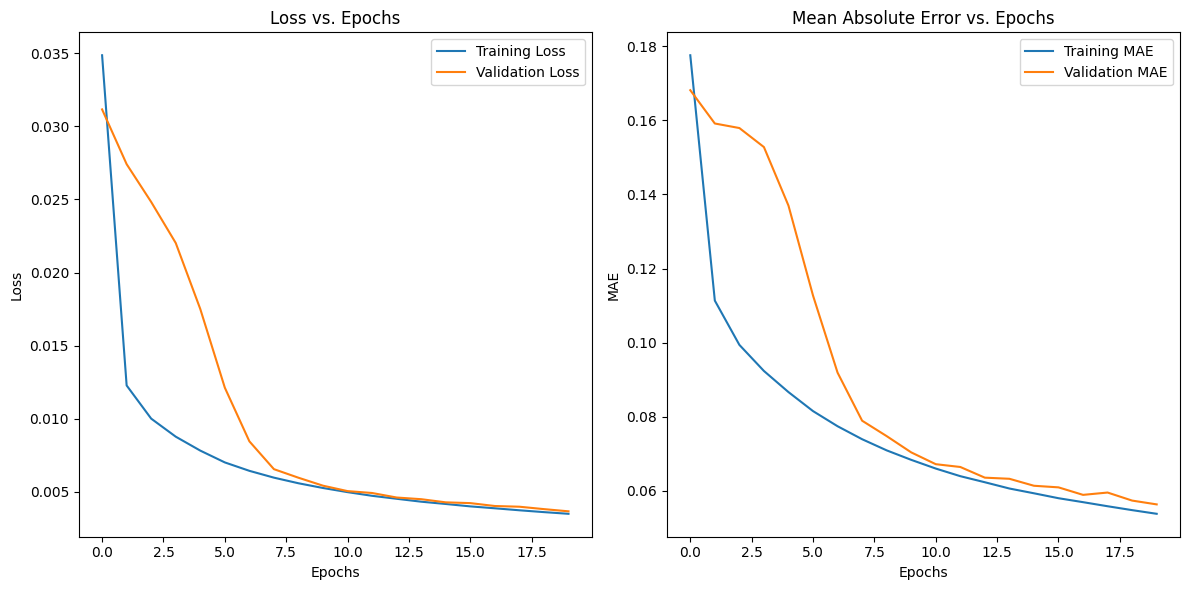

In [23]:
# To plot training and validation loss

train_loss = history.history['loss']
val_loss = history.history['val_loss']

train_mae = history.history['mae']
val_mae = history.history['val_mae']

# Plotting Loss
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting MAE
plt.subplot(1, 2, 2)
plt.plot(train_mae, label='Training MAE')
plt.plot(val_mae, label='Validation MAE')
plt.title('Mean Absolute Error vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()

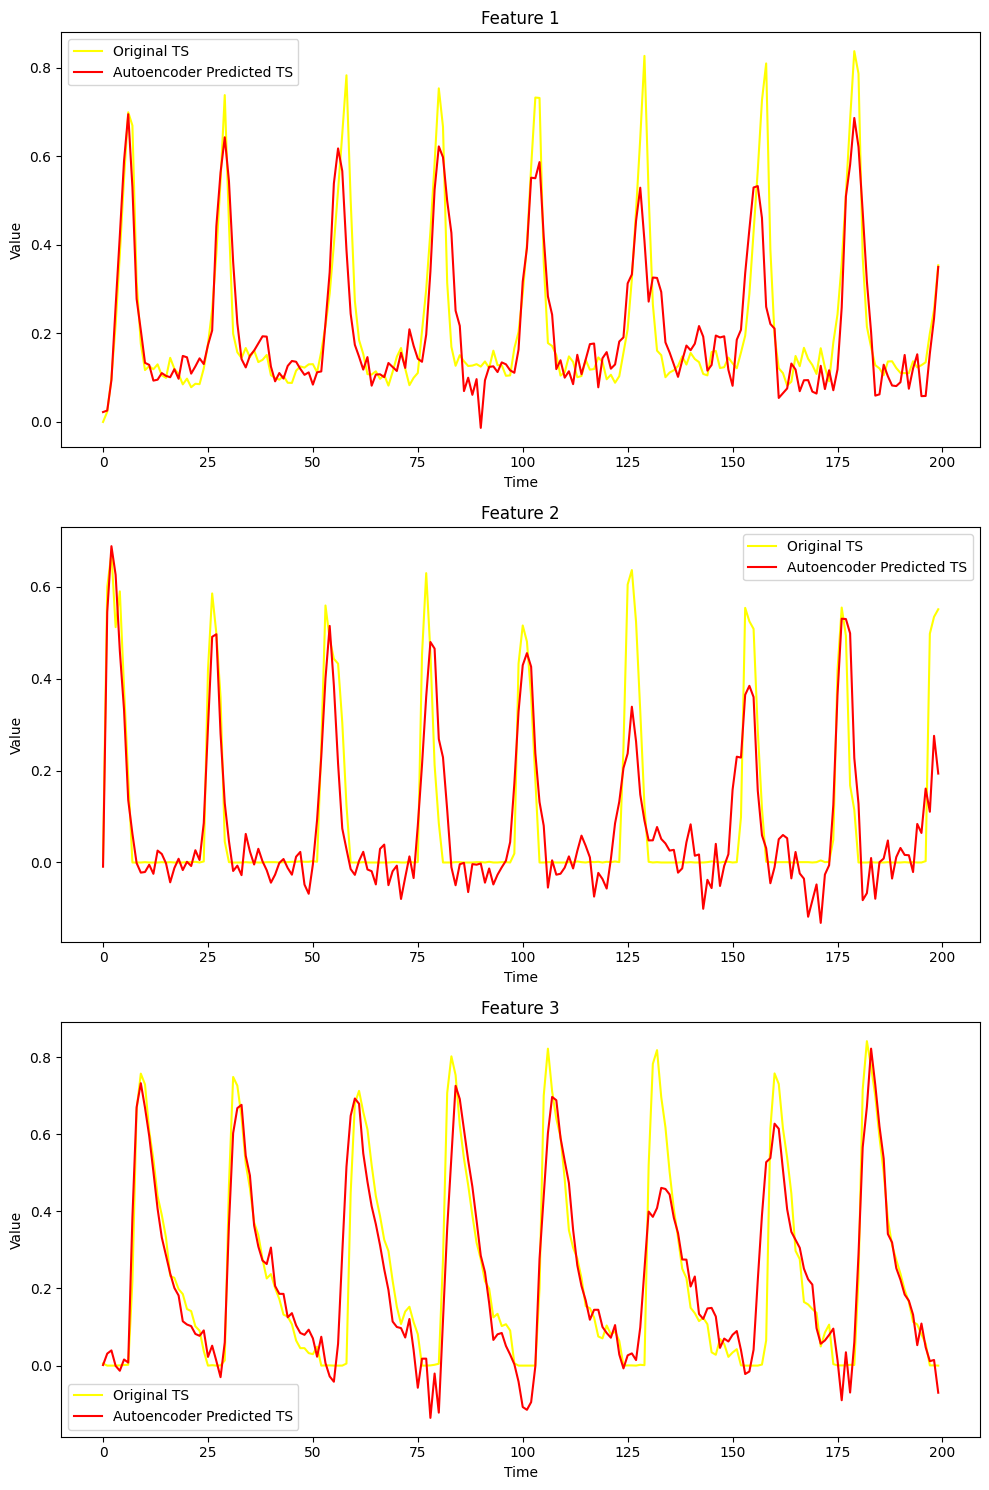

In [24]:
# Visual check to ensure predicted TS is similar to orginal TS
def autoencoder_test(model,scaler):
    
    random_params = np.random.uniform(low=dmin, high=dmax, size=(1, 15))

    ts_ = simulator(random_params[0])
    ts_ = ts_.transpose((0,2,1))

    random_ts_norm = scaler.transform(ts_.reshape(-1, ts_.shape[-1])).reshape(ts_.shape)

    test = np.array([append_mean_variance_to_sample(sample) for sample in random_ts_norm])
    pred_ts_norm = model.predict(test, verbose=False)


    plt.figure(figsize=(10, 15))
    time = np.arange(200)

    for i in range(3):
        plt.subplot(3, 1, i+1)
        plt.plot(time, random_ts_norm[0, :, i], color='yellow', label='Original TS')
        plt.plot(time, pred_ts_norm[0, :, i], color='red', label='Autoencoder Predicted TS')
        plt.title(f'Feature {i+1}')
        plt.xlabel('Time')
        plt.ylabel('Value')
        plt.legend()

    plt.tight_layout()
    plt.show()

autoencoder_test(autoencoder,scaler)

In [25]:
# Format for ABC to take custom summary statistics

class Encoder_Statistics(SummaryBase):

    def __init__(self, mean_trajectories=False, use_logger=False):
        self.name = 'ANN_Statistics'
        super(Encoder_Statistics, self).__init__(self.name, mean_trajectories, use_logger)
        if self.use_logger:
            self.logger = ml.SciopeLogger().get_logger()
            self.logger.info("Encoder_Statistics summary statistic initialized")

    def compute(self, data):
        data_arr = np.array(data)
        assert len(data_arr.shape) == 3, "required input shape is (n_points, n_species, n_timepoints)"


        data = np.array(data).transpose((0, 2, 1))


        data_scaled = scaler.transform(data.reshape(-1, data.shape[-1])).reshape(data.shape)

        pred_summary_stats_scaled = autoencoder.encoder(data_scaled)
        pred_summary_stats_scaled = np.array(pred_summary_stats_scaled)
        final_output = pred_summary_stats_scaled


        if self.mean_trajectories:
            res = np.asarray(np.mean(pred_summary_stats_unscaled, axis=0))  # returns a scalar, so we cast it as an array

        if self.use_logger:
            self.logger.info("Encoder_Statistics summary statistic: processed data matrix of shape {0} and generated summaries"
                            " of shape {1}".format(pred_summary_stats_scaled.shape, pred_summary_stats_scaled.shape))

        return final_output

enc_stat = Encoder_Statistics()

In [26]:
# ABC Inference

prior = UniformPrior(np.array(dmin), np.array(dmax))
obs_data = simulator(true_params)

abc = ABC(obs_data, simulator, prior, summaries_function=enc_stat.compute, epsilon=0.4)
abc.compute_fixed_mean(chunk_size=1)
res = abc.infer(num_samples=30, batch_size=1, chunk_size=1)


In [27]:
from sklearn.metrics import mean_absolute_error

# Reshape the inferred parameters to match true_params
inferred_params_reshaped = res['inferred_parameters'].reshape(1, 15)

# Calculate the MAE metric
mae_inference = mean_absolute_error(true_params, inferred_params_reshaped)

print(f'Mean Absolute Error: {mae_inference}')


Mean Absolute Error: 21.240551413204624
